## Цель работы 

Знакомство и освоение работы с дополнительными методами машинного обучения для решения задачи регрессии библиотеки sklearn.

## Ход работы
Ознакомиться с методическими материалами и примерами выполнения команд.
Последовательно выполнить следующие шаги применительно к выборке данных, согласно варианту задания:

1. Загрузка данных

    1. Выполнить загрузку файла с подготовленным набором данных (отчищенный от пропусков и выбросов для целевой и независимых переменных) в таблицу _df_
   
    2. Объявить список независимых и целевой переменных
   
    3. Оставить в таблице данных _df_ столбцы, относящиеся только к списку независимых и целевой переменных
   


2. Выполнить процедуры стандартизации каждого признака (столбца) и сохранить в отдельную таблицу _df_scaled_

    1. Получите величину среднего значения и среднеквадратического отклонения для целевой переменной
   
    2. Для целевой переменной построить гистограммы распределения стандартизированых и  исходных значений 
   
  
3. Разделите каждую из таблиц _df_ и _df_scaled_ на обучающую и проверочную части:

    1. Выберите значение для начального состояния генератора случайных чисел (ГСЧ) 

    2. Получите результат разделения таблицы _df_ (НЕ стандартизированная выборка): _x__train_ , _x__test_ , _y__train_ , _y__test_
    2. Получите результат разделения таблицы _df_scaled_ (Стандартизированная выборка): _xStd__train_ , _xStd__test_ , _yStd__train_ , _yStd__test_
   

4. Построить две модели методом SGDRegressor: на НЕ стандартизированных  (m1) и на стандартизированных (m2) данных. Для каждой из моделей m1, m2:

    1. Получить метрики RMSE, R2
   
    2. Построить диаграмму рассеяния вычисленных значений от проверочных значений
   
    3. Построить гистограмму остатков (разностей между вычисленными и проверочными)
   


5. Вернитесь к части соответствующей пунктку 3.1 и измените значение для начального состояния генератора случайных чисел (ГСЧ). Повторите разделение и вычисления соостветсвующие п. 3.2, 3.3, 4.1 - 4.4 хода работы

6. Сравнить полученные результаты и сделать заключение о:
    - Влияние операции стандартизации на точность моделей (изменение R^2 и RMSE у моделей m1 и m2) 
    - Влияние перемешивания при разделении (изменение R^2 и RMSE при различных rand_seed),  
   
5. Используя модель SGDRegressor и прием кросс-валидации получить на проверочной части (*_test) НЕ стандартизированных и стандартизированных данных следующие оценки точности: 

    1. R2(коэфф. детерминации) 
   
    2. RMSE (среднеквадратичное отклонение)


|Оценка|на станд.| на НЕ станд.|
|-|-|-|
|Разделений|k=...|
|R2|[r2Std_1, r2Std_2, ...]|[r2_1, r2_2, ...]|
|R2 средн| 0.xx|0.xx|
|RMSE|[rmseStd_1, rmseStd_2, ...]|[rmse_1, rmse_2, ...]|
|RMSE средн|x.xx|x.xx|

6. Провести сравнение полученных значений и сделать заключение о велечине коридора изменений оценок моделей

## Начало: подгружаем библиотеки

In [1]:
# Python 3.8
import pandas as pd #обработка (загрузка, сохранение, анализа) данных
import numpy  as np #обработка многомерных массивов, линейная алгебра, преобразование Фурье, случайные числа

from sklearn import linear_model # (классификация, регрессия, кластеризация...)
from sklearn import metrics
from sklearn import datasets
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

import scipy #пакет для выполнения научных и инженерных расчётов.
import seaborn as sns #визуализация данных (на базе matplotlib)

### Объявление функций

Для повышения повторяемости кода и повышения уровня читаемости объявим несколько функций с уже знакомыми операциями

In [2]:
def PLOT34(y_test, y_pred):
    '''
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменный
    :param y_pred: - вычисленные значения целевой переменный
    '''
    plt.figure(figsize=(12,6))
    
    # == Диаграмма рассеяния вычисленных значений ==
    # создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс текущего полотна в сетке
    plt.subplot(121)
    plt.scatter(y_test, y_pred,  alpha=0.1)
    plt.scatter(y_test, y_test,  alpha=0.1)
    plt.title('Диаграмма рассеяния вычисленных значений');
    plt.xlabel('Проверочное Y')
    plt.ylabel('Вычисленное Y')

    
    # == Диаграмма рассеяния ошибок ==
    # создать первое полотно 121: 1-строк, 2-столбцов, 2-индекс текущего полотна в сетке
    plt.subplot(122)
    plt.scatter(y_test, (y_test - y_pred)**2,  alpha=0.1)
    plt.title('Диаграмма рассеяния квадрата абсолютной ошибки')
    plt.xlabel('Проверочное Y')
    plt.ylabel('Квадрат абсолютной ошибки')
#--------------------------------------------------------------------------

In [ ]:
def GET_METRICS_SINGLE(y_test, y_pred):
    '''
    Вычисление и вывод метрик: MAE, RMSE, R2.
    На основе сравнения проверочных и вычисленных.
    :param y_test: - проверочные значения целевой переменный
    :param y_pred: - вычисленные значения целевой переменный
    '''
    mae  = metrics.mean_absolute_error        (y_test, y_pred)
    mse  = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = metrics.r2_score                   (y_test, y_pred)

    print ("MAE : {:>9,.3f} (средняя абсолютная ошибка)".format              ( mae ))
    print ("MSE : {:>9,.6f} (среднеквадратичная ошибка)".format( mse ))
    print ("RMSE: {:>9,.6f} (кв. корень из среднеквадратичной ошибки)".format( rmse ))
    print ("R2  : {:>9,.3f} (коэфф. детерминации)".format                    ( r2 ))
#--------------------------------------------------------------------------

In [3]:
DataFrame=pd.read_csv('../data/insurance_data_Ready.csv',sep=',',header=0)

DataFrame.query("`smoker_no` == 1 and `sex_female` == 1", inplace=True)
target=['charges']
features=['smoker_yes','age','bmi','reg_southeast','children']
DataFrame =  DataFrame [features + target]
DataFrame[:5]

FileNotFoundError: ignored

Важнейшими числовыми характеристиками случайной величины являются:

- Математическое ожидание, имеющее смысл среднего значения  (mean)  $ {\\mu} $ (мю) - центр распределения случайной величины
      .mean() - expected value - ожидаемое зачение 
      
- Среднеквадратическое отклонение (Standard_deviation) $ {\\sigma} $ (сигма) - показатель рассеивания относительно её ожидаемого значения
      .std()
      
- Дисперсия (Variance) $ {\\var = sigma^2} $ (сигма в квадрате) - мера разброса относительно её ожидаемого значения
      .var  =  .std()**2


Среднекв. откл. на примере возраста 14.142135623730951
Дисперсия на примере возраста 200.0
Ожидаемое значение на примере возраста 40.0


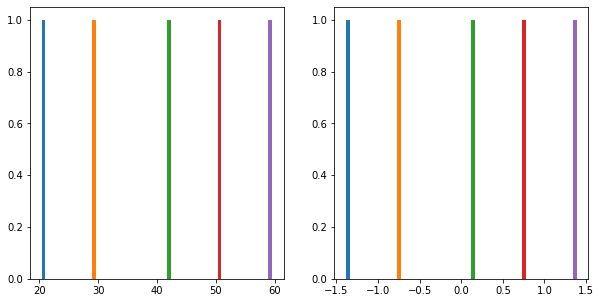

In [4]:
#Пример операции стандартизации
#DataFrame_x1 = pd.DataFrame(np.array([20,25,30,35,40,45,50,55,60,65]))
DataFrame_x1 = pd.DataFrame(np.array([20,30,40,50,60]))
print ("Среднекв. откл. на примере возраста", DataFrame_x1.std(ddof=0)[0])
print ("Дисперсия на примере возраста", DataFrame_x1.var(ddof=0)[0])
print ("Ожидаемое значение на примере возраста", DataFrame_x1.mean()[0])

# X_stantartised = (X - X.mean()) / X.std()
DataFrame_standard = (DataFrame_x1 - DataFrame_x1.mean())/DataFrame_x1.std(ddof=0)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(DataFrame_x1)
plt.subplot(122)
plt.hist(DataFrame_standard); 

In [ ]:
DataFrame_scaled = (DataFrame - DataFrame.mean()) / DataFrame.std(ddof=0) # обязательный параметр ddof=0
DataFrame_scaled[:5]

,smoker_yes,age,bmi,reg_southeast,children,charges
4,NaN,-0.719612,-0.818803,1.741191,-0.926987,-0.884436
5,NaN,0.384363,0.505994,1.741191,-0.099378,-0.132263
6,NaN,-0.278022,-0.474700,-0.574320,1.555839,-0.293147
8,NaN,1.414739,-0.801597,-0.574320,-0.926987,3.337177
11,NaN,1.120346,1.603683,1.741191,-0.926987,0.345838


In [ ]:
scaler = StandardScaler()
#Вычисление значений среднего и дисперсии отдельно для каждого признака
scaler.fit(DataFrame)

print (" {:>3} {:<25} {:>16} {:>16}".format("№", "Признак", "Средрее", "Ср.кв.откл."))
for icol in range (0, len(DataFrame.columns)):
    print (" {:>3} {:<25} {:>16.3f} {:>16.3f}".format(
                   icol, 
                   DataFrame.columns[icol],
                   scaler.mean_[icol],
                   np.sqrt ( scaler.var_[icol]),
                  )
          )
scaler.transform(DataFrame)

   № Признак                            Средрее      Ср.кв.откл.
   0 smoker_yes                           0.000            0.000
   1 age                                 40.778           13.587
   2 bmi                                 30.499            5.812
   3 reg_southeast                        0.248            0.432
   4 children                             1.120            1.208
   5 charges                           9029.055         5961.351


array([[ 0.        , -0.71961174, -0.81880264,  1.74119098, -0.92698676,
        -0.88443594],
       [ 0.        ,  0.38436279,  0.50599402,  1.74119098, -0.09937819,
        -0.13226287],
       [ 0.        , -0.27802193, -0.47469961, -0.57431954,  1.55583894,
        -0.29314652],
       ...,
       [ 0.        ,  0.8259526 ,  2.44329406, -0.57431954,  1.55583894,
         0.39967951],
       [ 0.        , -1.67638967,  0.24447572, -0.57431954, -0.92698676,
        -1.14455159],
       [ 0.        , -1.45559476, -0.80847955, -0.57431954, -0.92698676,
        -1.17777154]])

In [ ]:
# создать новую таблицу (DataFrame) 
# со стандартизированными значениями

DataFrame_scaled = pd.DataFrame (
  data    = scaler.transform(DataFrame), # значения ячеек
  columns = DataFrame.columns,           # названия столбцов
  index   = DataFrame.index              # идентификаторы строк
)
DataFrame_scaled[:5]


,smoker_yes,age,bmi,reg_southeast,children,charges
4,0.0,-0.719612,-0.818803,1.741191,-0.926987,-0.884436
5,0.0,0.384363,0.505994,1.741191,-0.099378,-0.132263
6,0.0,-0.278022,-0.474700,-0.574320,1.555839,-0.293147
8,0.0,1.414739,-0.801597,-0.574320,-0.926987,3.337177
11,0.0,1.120346,1.603683,1.741191,-0.926987,0.345838


In [ ]:

# Результат обратного преобразования обернутые в таблицу (DataFrame) 
pd.DataFrame (scaler.inverse_transform(  DataFrame_scaled [0:1]  ))
DataFrame[:5]

,smoker_yes,age,bmi,reg_southeast,children,charges
4,0,31.0,25.74,1,0.0,3756.62160
5,0,46.0,33.44,1,1.0,8240.58960
6,0,37.0,27.74,0,3.0,7281.50560
8,0,60.0,25.84,0,0.0,28923.13692
11,0,56.0,39.82,1,0.0,11090.71780


## Информация по целевой переменной
Получите величину среднего значения и дисперсии для целевой переменной

In [ ]:
DataFrame_scaled = pd.DataFrame (
  data    = scaler.transform(DataFrame), # значения ячеек
  columns = DataFrame.columns,           # названия столбцов
  index   = DataFrame.index              # идентификаторы строк
)
print (" {:>3} {:<25} {:>16} {:>16} {:>16}".format(
 "№", "Признак", "Средрее", "Ср.кв.откл.","Дисперсия"
))
for icol in range (5, 6):
    print (" {:>3} {:<25} {:>16.3f} {:>16.3f} {:>17.3f}".format(
                   icol, 
                   DataFrame.columns[icol],
                   scaler.mean_[icol],
                   np.sqrt ( scaler.var_[icol]), # кв. корень (из дисперсии)
                   scaler.var_[icol],
                  )
          )

   № Признак                            Средрее      Ср.кв.откл.        Дисперсия
   5 charges                           9029.055         5961.351      35537710.625


Построить гистограммы распределения исходных и стандартизированных значений для целевого признака

Среднекв. откл. для целевого признака 17078.25127659933
Дисперсия  для целевого признака 291666666.6666667
Ожидаемое значение  для целевого признака 25000.0
Среднекв. откл. 17078.25127659933


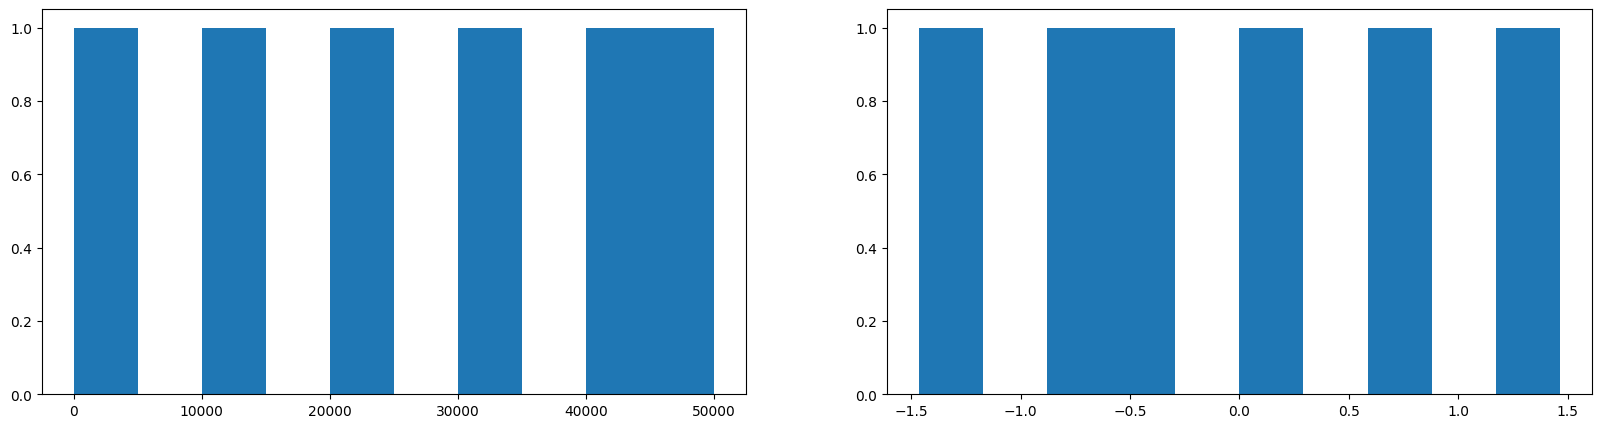

In [ ]:
# Пример операции стандартизации
from math import sqrt

DataFrame_x1 = pd.DataFrame(np.array([0, 10000,20000,30000,40000, 50000]))
print ("Среднекв. откл. для целевого признака", DataFrame_x1.std(ddof=0)[0])
print ("Дисперсия  для целевого признака", DataFrame_x1.var(ddof=0)[0])
print ("Ожидаемое значение  для целевого признака", DataFrame_x1.mean()[0])

DataFrame_standard = (DataFrame_x1 - DataFrame_x1.mean())/DataFrame_x1.std(ddof=0)
D_std=sqrt(DataFrame_x1.var(ddof=0)[0])

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(DataFrame_x1)
plt.subplot(122)
plt.hist(DataFrame_standard); 
print("Среднекв. откл.",D_std)

## Формирование тренировочной и проверочной выборок (случайное состояние = 5)

In [ ]:
# Результат обратного преобразования обернутые в таблицу (DataFrame) 
#pd.DataFrame (scaler.inverse_transform(  DataFrame_scaled [0:1]  ))
target=['charges']
features=['smoker_yes','age','bmi','reg_southeast','children']
x_train, x_test, y_train, y_test =  train_test_split(
    DataFrame[features],    # исходные данные X
    DataFrame[target],      # исходные данные y
    test_size = 0.3, random_state=5, shuffle=True          
) 
y_train = y_train['charges']
y_test = y_test['charges']

print ("Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(y_test), 
    len(x_train)+len(x_test), len(y_train)+len(y_test),
))

Кол-во элементов: 
  x_train: 355, y_train 355 
  x_test:  153, y_test  153 
  total x: 508, total y 508 


In [ ]:
target=['charges']
features=['smoker_yes','age','bmi','reg_southeast','children']
xStd_train, xStd_test, yStd_train, yStd_test =  train_test_split(
    DataFrame_scaled[features], 
    DataFrame_scaled[target], 
    test_size = 0.3, random_state=5, shuffle=True 
) 
yStd_train = yStd_train['charges']
yStd_test = yStd_test['charges']

print ("Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y: {} ".format  (
    len(xStd_train), len(yStd_train),
    len(xStd_test),  len(yStd_test), 
    len(xStd_train)+len(xStd_test), len(yStd_train)+len(yStd_test),
))


Кол-во элементов: 
  x_train: 355, y_train 355 
  x_test:  153, y_test  153 
  total x: 508, total y: 508 


### Модель SGDRegressor. НЕ стандартизованные

In [ ]:
# 1. Создать объект класса с моделью стохастического градиентного спуска
#Data_model_nonStd = linear_model.SGDRegressor(loss='squared_error', max_iter=10000, tol=0.0001, random_state=5, )
Data_model_nonStd = SGDRegressor(max_iter=10000,tol=1e-3, random_state=5)
# 2. Обучим модель (подберем/подогоним параметры модели)  на НЕ СТАНДАРТИЗИРОВАНОМ проверочном наборе
Data_model_nonStd.fit(x_train,  y_train)

SGDRegressor(max_iter=10000, random_state=5)

In [ ]:

# 3. Получить вычисленные(predicted) зн. на НЕ СТАНДАРТИЗИРОВАНОМ проверочном наборе
y_pred_nonStd = Data_model_nonStd.predict(x_test)
y_pred_nonStd[:10]

array([-5.43557565e+11, -1.04310347e+12, -8.32098865e+11, -1.03858787e+12,
       -1.01879515e+12, -6.21755539e+11, -9.10239941e+11, -7.41108322e+11,
       -7.46469465e+11, -1.00696728e+12])

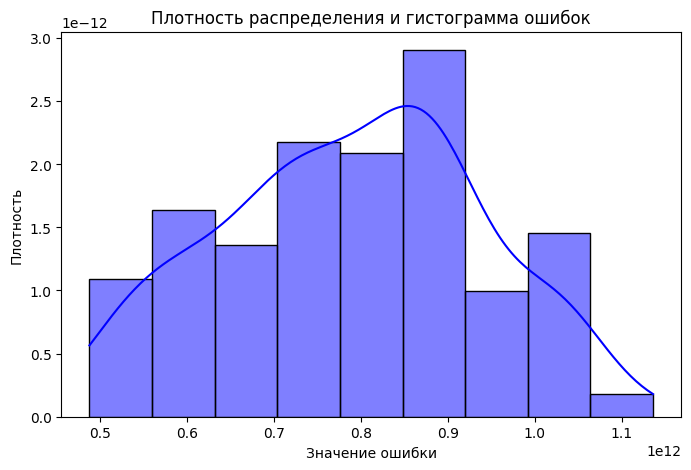

In [ ]:
# 4. Построить графики для оценки ошибки (вычисленные от проверочных)
#Для оценки точности построим гистограмму распределения ошибок
plt.figure(figsize=(8,5))
# Гистограмма и Плотность распределения
sns.histplot(y_test - y_pred_nonStd, color="blue",  kde=True, stat="density",)
# Осевая линия
#plt.plot( [0, 0], [0, 10 * pow(10,-7)], '--', lw=3, c='r')
plt.ylabel(u'Плотность')
plt.xlabel(u'Значение ошибки')
plt.title(u'Плотность распределения и гистограмма ошибок')
plt.show()

MAE : 789,631,255,528.694 (средняя абсолютная ошибка)
MSE : 645,447,039,020,357,155,553,280.000000 (среднеквадратичная ошибка)
RMSE: 803,397,186,340.826782 (кв. корень из среднеквадратичной ошибки)
R2  : -15,886,580,226,130,476.000 (коэфф. детерминации)


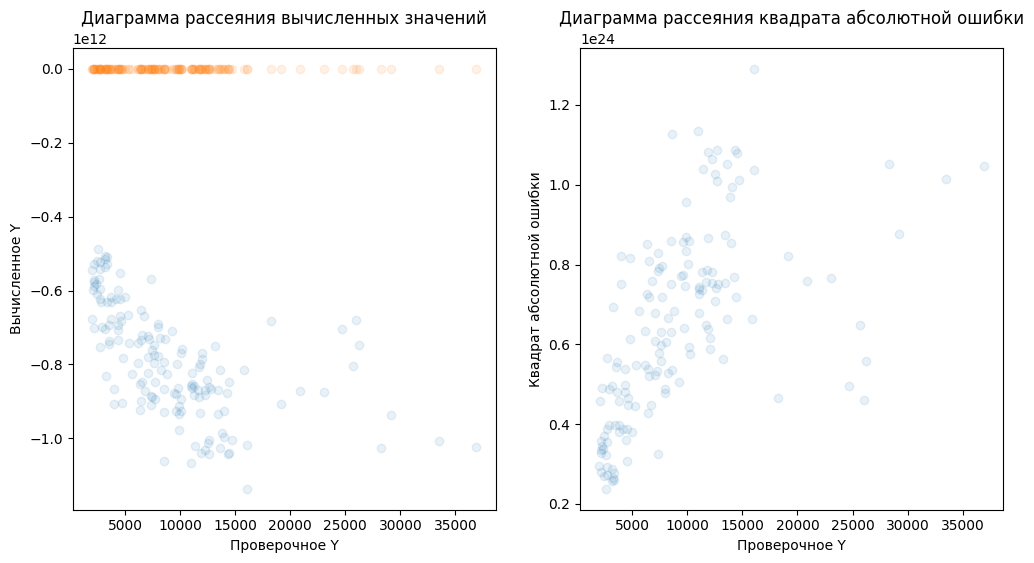

In [ ]:
GET_METRICS_SINGLE(y_test, y_pred_nonStd)
PLOT34(y_test, y_pred_nonStd)

### Стандартизованные

In [ ]:

# 1. Создать объект класса с моделью стохастического градиентного спуска
Data_model_Std =   SGDRegressor(max_iter=10000, tol=1e-3, random_state=5, )
# 2. Обучим модель (подберем/подогоним параметры модели)  на НЕ СТАНДАРТИЗИРОВАНОМ проверочном наборе
Data_model_Std.fit(xStd_train,  yStd_train)
# 3. Получить вычисленные(predicted) зн. на СТАНДАРТИЗИРОВАНОМ проверочном наборе
y_pred_Std = Data_model_Std.predict (xStd_test)
#y_pred_Std[:10]
#xStd_test

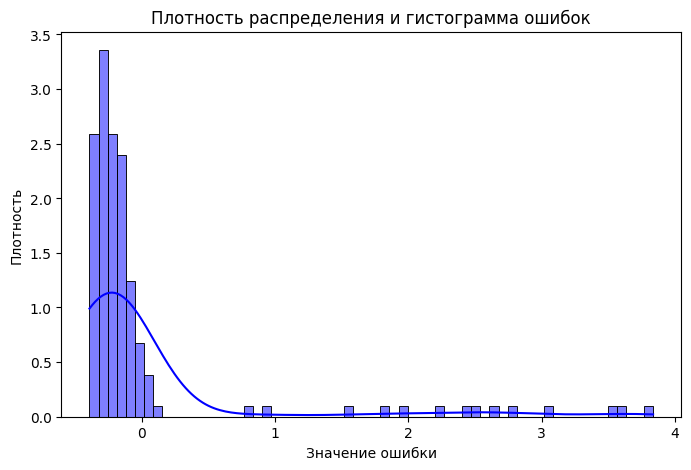

In [ ]:
# 4. Построить графики для оценки ошибки (вычисленные от проверочных)
#Для оценки точности построим гистограмму распределения ошибок
plt.figure(figsize=(8,5))
# Гистограмма и Плотность распределения
sns.histplot(yStd_test - y_pred_Std, color="blue",  kde=True, stat="density",)
# Осевая линия
#plt.plot( [0, 0], [0, 10 * pow(10,-7)], '--', lw=3, c='r')
plt.ylabel(u'Плотность')
plt.xlabel(u'Значение ошибки')
plt.title(u'Плотность распределения и гистограмма ошибок')
plt.show()

MAE :     0.423 (средняя абсолютная ошибка)
MSE :  0.661226 (среднеквадратичная ошибка)
RMSE:  0.813158 (кв. корень из среднеквадратичной ошибки)
R2  :     0.422 (коэфф. детерминации)


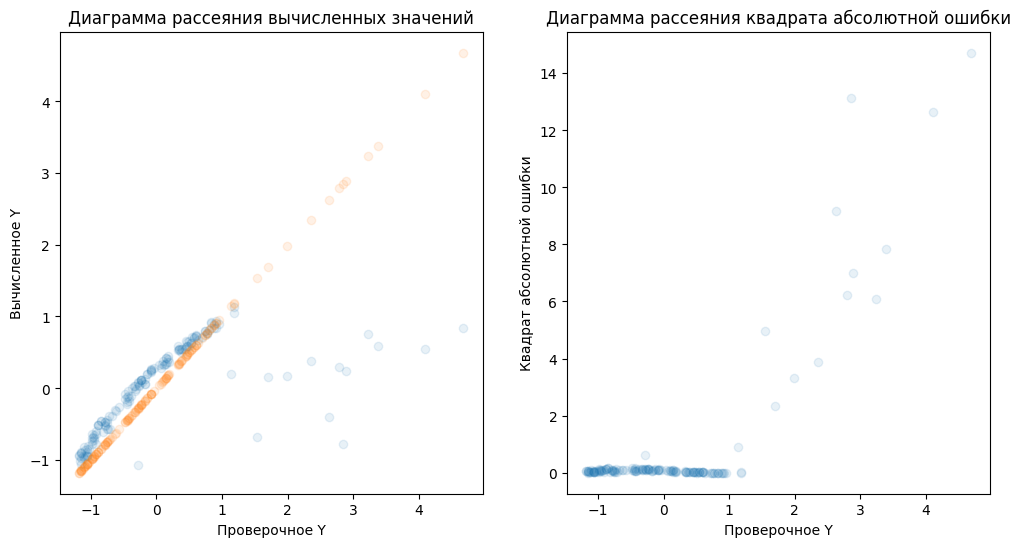

In [ ]:
GET_METRICS_SINGLE(yStd_test, y_pred_Std)
PLOT34(yStd_test, y_pred_Std)

## Формирование тренировочной и проверочной выборок (случайное состояние = 2)

In [ ]:
# Результат обратного преобразования обернутые в таблицу (DataFrame) 
#pd.DataFrame (scaler.inverse_transform(  DataFrame_scaled [0:1]  ))
target=['charges']
features=['smoker_yes','age','bmi','reg_southeast','children']
x_train, x_test, y_train, y_test =  train_test_split(
    DataFrame[features],    # исходные данные X
    DataFrame[target],      # исходные данные y
    test_size = 0.2, random_state=2, shuffle=True          
) 
y_train = y_train['charges']
y_test = y_test['charges']

print ("Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(y_test), 
    len(x_train)+len(x_test), len(y_train)+len(y_test),
))

Кол-во элементов: 
  x_train: 406, y_train 406 
  x_test:  102, y_test  102 
  total x: 508, total y 508 


In [ ]:
target=['charges']
features=['smoker_yes','age','bmi','reg_southeast','children']
xStd_train, xStd_test, yStd_train, yStd_test =  train_test_split(
    DataFrame_scaled[features], 
    DataFrame_scaled[target], 
    test_size = 0.2, random_state=2, shuffle=True 
) 
yStd_train = yStd_train['charges']
yStd_test = yStd_test['charges']

print ("Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y: {} ".format  (
    len(xStd_train), len(yStd_train),
    len(xStd_test),  len(yStd_test), 
    len(xStd_train)+len(xStd_test), len(yStd_train)+len(yStd_test),
))


Кол-во элементов: 
  x_train: 406, y_train 406 
  x_test:  102, y_test  102 
  total x: 508, total y: 508 


### Модель SGDRegressor. НЕ стандартизованные

In [ ]:
# 1. Создать объект класса с моделью стохастического градиентного спуска
#Data_model_nonStd = linear_model.SGDRegressor(loss='squared_error', max_iter=10000, tol=0.0001, random_state=5, )
Data_model_nonStd = SGDRegressor(max_iter=10000,tol=1e-3, random_state=2)

In [ ]:
# 2. Обучим модель (подберем/подогоним параметры модели)  на НЕ СТАНДАРТИЗИРОВАНОМ проверочном наборе
Data_model_nonStd.fit(x_train,  y_train)

SGDRegressor(max_iter=10000, random_state=2)

In [ ]:

# 3. Получить вычисленные(predicted) зн. на НЕ СТАНДАРТИЗИРОВАНОМ проверочном наборе
y_pred_nonStd = Data_model_nonStd.predict(x_test)
#y_pred_nonStd[:10]

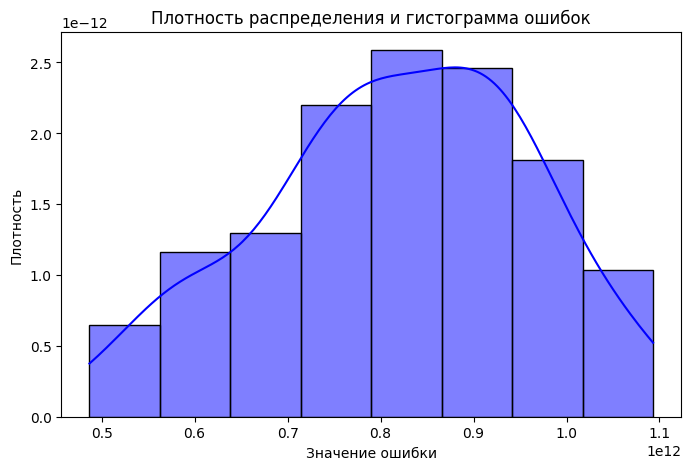

In [ ]:
# 4. Построить графики для оценки ошибки (вычисленные от проверочных)
#Для оценки точности построим гистограмму распределения ошибок
plt.figure(figsize=(8,5))
# Гистограмма и Плотность распределения
sns.histplot(y_test - y_pred_nonStd, color="blue",  kde=True, stat="density",)
# Осевая линия
#plt.plot( [0, 0], [0, 10 * pow(10,-7)], '--', lw=3, c='r')
plt.ylabel(u'Плотность')
plt.xlabel(u'Значение ошибки')
plt.title(u'Плотность распределения и гистограмма ошибок')
plt.show()

MAE : 816,863,732,022.007 (средняя абсолютная ошибка)
MSE : 687,592,764,812,224,502,956,032.000000 (среднеквадратичная ошибка)
RMSE: 829,212,134,988.522949 (кв. корень из среднеквадратичной ошибки)
R2  : -17,943,650,435,498,972.000 (коэфф. детерминации)


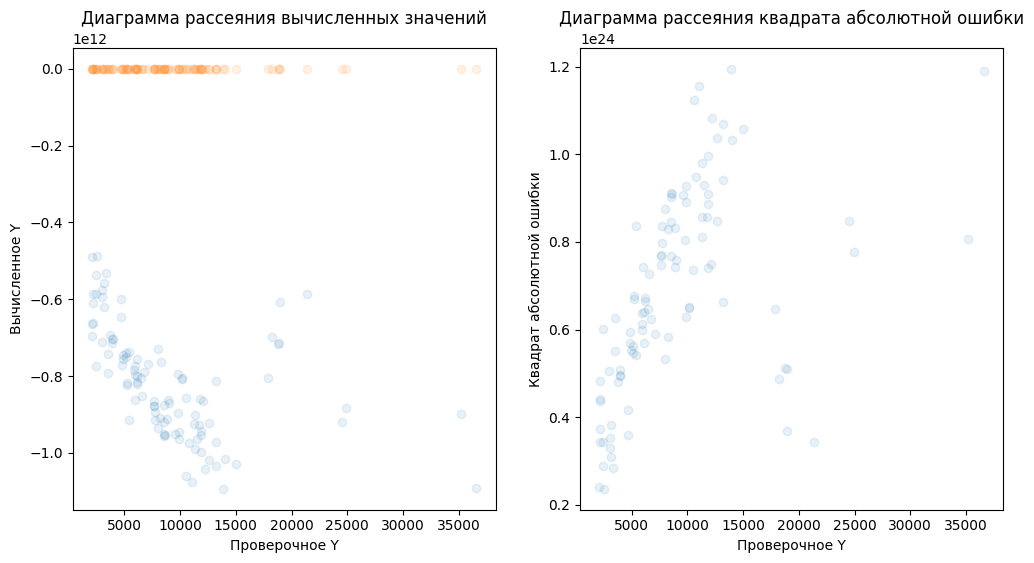

In [ ]:
GET_METRICS_SINGLE(y_test, y_pred_nonStd)
PLOT34(y_test, y_pred_nonStd)

### Стандартизованные

In [ ]:

# 1. Создать объект класса с моделью стохастического градиентного спуска
Data_model_Std =   SGDRegressor(max_iter=10000, tol=1e-3, random_state=2)
# 2. Обучим модель (подберем/подогоним параметры модели)  на НЕ СТАНДАРТИЗИРОВАНОМ проверочном наборе
Data_model_Std.fit(xStd_train,  yStd_train)
# 3. Получить вычисленные(predicted) зн. на СТАНДАРТИЗИРОВАНОМ проверочном наборе
y_pred_Std = Data_model_Std.predict (xStd_test)
#y_pred_Std[:10]
#xStd_test

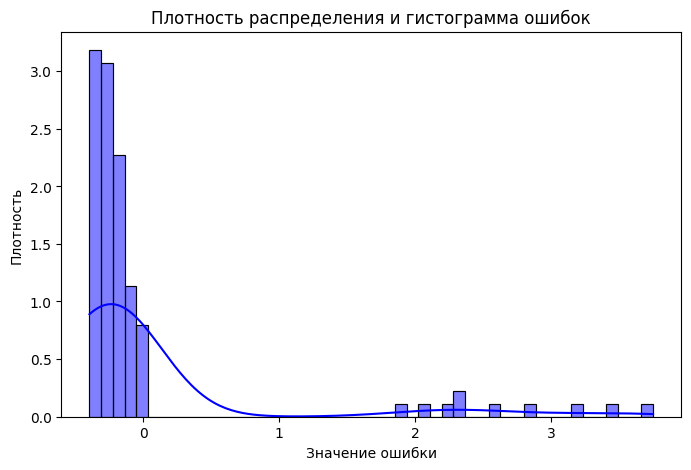

In [ ]:
# 4. Построить графики для оценки ошибки (вычисленные от проверочных)
#Для оценки точности построим гистограмму распределения ошибок
plt.figure(figsize=(8,5))
# Гистограмма и Плотность распределения
sns.histplot(yStd_test - y_pred_Std, color="blue",  kde=True, stat="density",)
# Осевая линия
#plt.plot( [0, 0], [0, 10 * pow(10,-7)], '--', lw=3, c='r')
plt.ylabel(u'Плотность')
plt.xlabel(u'Значение ошибки')
plt.title(u'Плотность распределения и гистограмма ошибок')
plt.show()

Text(0, 0.5, 'Абсолютная ошибка')

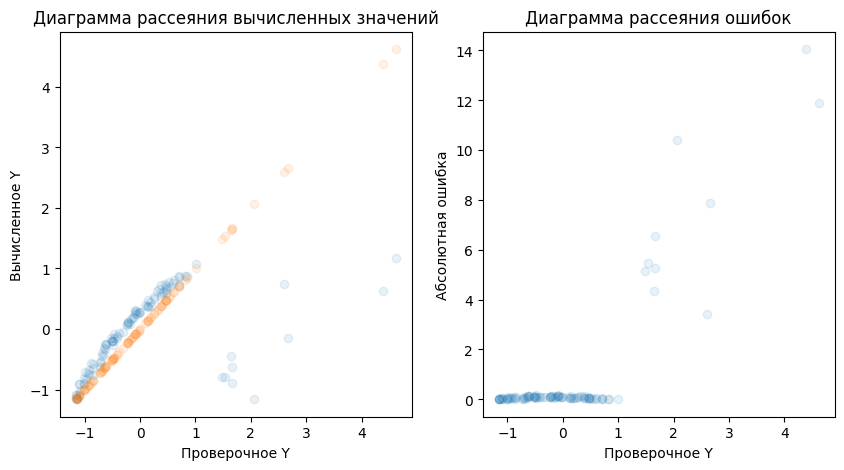

In [ ]:
#Построим графики для визуальной оценки качества модели
plt.figure(figsize=(10,5))
# создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс в сетке
plt.subplot(121)
plt.scatter(yStd_test, y_pred_Std,  alpha=0.1)
plt.scatter(yStd_test, yStd_test,  alpha=0.1)#красная линия
plt.title('Диаграмма рассеяния вычисленных значений')
plt.xlabel('Проверочное Y')
plt.ylabel('Вычисленное Y')
# создать первое полотно 121: 1-строк, 2-столбцов, 2-индекс в сетке
plt.subplot(122)
plt.scatter(yStd_test, (yStd_test - y_pred_Std)**2,  alpha=0.1)
plt.title('Диаграмма рассеяния ошибок')
plt.xlabel('Проверочное Y')
plt.ylabel('Абсолютная ошибка')

In [ ]:
# 5. сравним реальные и вычисленные значениямя и получим важные оценки качества модели
print ("Cравним реальные и вычисленные значениямя и получим важные оценки качества модели")
r2_Std   = metrics.r2_score                   (yStd_test, y_pred_Std)
mae_Std  = metrics.mean_absolute_error        (yStd_test, y_pred_Std)
rmse_Std = np.sqrt( metrics.mean_squared_error(yStd_test, y_pred_Std))

print ("R2 - коэфф. детерминации:        {:>7,.3f}".format               ( r2_Std ))
print ("MAE - средняя абсолютная ошибка: {:>7,.3f}".format               ( mae_Std ))
print ("RMSE - кв. корень из среднеквадратичной ошибки: {:>7,.3f}".format( rmse_Std ))

Cравним реальные и вычисленные значениямя и получим важные оценки качества модели
R2 - коэфф. детерминации:          0.269
MAE - средняя абсолютная ошибка:   0.471
RMSE - кв. корень из среднеквадратичной ошибки:   0.888


# Кросс-валидация

In [ ]:
modelForCV =  linear_model.SGDRegressor(max_iter=10000,tol=1e-3,random_state=5)

print("R2. НЕ Стандартизированные  проверочные данные")
scores_cross = cross_val_score(estimator = modelForCV, X=x_test, y=y_test, cv=6, scoring='r2')
print("Усредненное значение метрики:", scores_cross.mean())
print("\nЗначения метрики по каждому блоку cv:", scores_cross)

print("\nRMSE. НЕ Стандартизированные проверочные данные")
scores_cross = cross_val_score(estimator = modelForCV, X=x_test, y=y_test, cv=6, scoring='neg_root_mean_squared_error')
print("Усредненное значение метрики:", scores_cross.mean())
print("\nЗначения метрики по каждому блоку cv:", scores_cross)

print("\nMSE. НЕ Стандартизированные проверочные данные")
scores_cross = cross_val_score(estimator = modelForCV, X=x_test, y=y_test, cv=6, scoring='neg_mean_squared_error')
print("Усредненное значение метрики:", scores_cross.mean())
print("\nЗначения метрики по каждому блоку cv:", scores_cross)


R2. НЕ Стандартизированные  проверочные данные
Усредненное значение метрики: -1.1014595394951038e+17

Значения метрики по каждому блоку cv: [-3.61822890e+16 -2.25528275e+16 -5.01443436e+17 -4.69940729e+16
 -5.28576856e+16 -8.45412740e+14]

RMSE. НЕ Стандартизированные проверочные данные
Усредненное значение метрики: -1247883252075.8523

Значения метрики по каждому блоку cv: [-7.17732348e+11 -6.14096535e+11 -3.05637225e+12 -1.61583651e+12
 -1.20390897e+12 -2.79352898e+11]

MSE. НЕ Стандартизированные проверочные данные
Усредненное значение метрики: -2.3953380149603234e+24

Значения метрики по каждому блоку cv: [-5.15139724e+23 -3.77114555e+23 -9.34141133e+24 -2.61092764e+24
 -1.44939680e+24 -7.80380415e+22]


In [ ]:
print("R2. Стандартизированные  проверочные данные")
scores_cross = cross_val_score(estimator = modelForCV, X=xStd_test, y=yStd_test, cv=6, scoring='r2')
print("Усредненное значение метрики:", scores_cross.mean())
print("\nЗначения метрики по каждому блоку cv:", scores_cross)

print("\nRMSE. Стандартизированные проверочные данные")
scores_cross = cross_val_score(estimator = modelForCV, X=xStd_test, y=yStd_test, cv=6, scoring='neg_root_mean_squared_error')
print("Усредненное значение метрики:", scores_cross.mean())
print("\nЗначения метрики по каждому блоку cv:", scores_cross)

print("\nMSE. Стандартизированные проверочные данные")
scores_cross = cross_val_score(estimator = modelForCV, X=xStd_test, y=yStd_test, cv=6, scoring='neg_mean_squared_error')
print("Усредненное значение метрики:", scores_cross.mean())
print("\nЗначения метрики по каждому блоку cv:", scores_cross)


R2. Стандартизированные  проверочные данные
Усредненное значение метрики: 0.16299734935316162

Значения метрики по каждому блоку cv: [0.09165283 0.03234598 0.30922225 0.19244043 0.13474184 0.21758076]

RMSE. Стандартизированные проверочные данные
Усредненное значение метрики: -0.8743427753503701

Значения метрики по каждому блоку cv: [-0.60324775 -0.67476334 -0.60175502 -1.12361735 -0.81708588 -1.42558732]

MSE. Стандартизированные проверочные данные
Усредненное значение метрики: -0.8572944998336821

Значения метрики по каждому блоку cv: [-0.36390785 -0.45530556 -0.3621091  -1.26251595 -0.66762933 -2.03229921]


## Сравнение полученных моделей и моделей из предыдущей ЛР

In [ ]:
DataResults = pd.DataFrame (
    [
        ["m1","НЕ СТАНДАРТ.","LinearRegression", 0.036  , 11837.908722 , 140136082.898854, 9285.379],
        ["m2","НЕ СТАНДАРТ.","LinearRegression", 0.741  , 6137.571402  , 37669782.713523 , 4345.338],
        ["m3","НЕ СТАНДАРТ.","LinearRegression", 0.003  , 12072.213745 , 145738344.716788, 9190.975],
        ["m4","НЕ СТАНДАРТ.","SGDRegressor", -1618494847.229, 439925706.551063, 193534627284352352.000000, 332444196.503],
        ["m4","СТАНДАРТ.","SGDRegressor", 0.710, 0.503300, 0.253311, 30.355],
        ["m4","НЕ СТАНДАРТ.","SGDRegressor", -1618494847.229, 439925706.551063, 193534627284452352.000000, 332444196.503],
    ],
    columns= ["набор данных", "тип данных", "модель обучения", "R2", "RMSE", "MSE", "MAE" ],
 )
print("MAE  - средняя абсолютная ошибка" +
    "\nMSE  - среднеквадратичная ошибка" +
    "\nRMSE - кв. корень из среднеквадратичной ошибки" +
    "\nR2   - коэфф. детерминации"+
    "\nНаборы данных:\tm1 - age"+
    "\n\tm2 -'age','bmi','smoker_yes'" +
    "\n\tm3 - children,reg_southeast,sex_female" )
DataResults


MAE  - средняя абсолютная ошибка
MSE  - среднеквадратичная ошибка
RMSE - кв. корень из среднеквадратичной ошибки
R2   - коэфф. детерминации
Наборы данных:	m1 - age
	m2 -'age','bmi','smoker_yes'
	m3 - children,reg_southeast,sex_female


,набор данных,тип данных,модель обучения,R2,RMSE,MSE,MAE
0,m1,НЕ СТАНДАРТ.,LinearRegression,3.600000e-02,1.183791e+04,1.401361e+08,9.285379e+03
1,m2,НЕ СТАНДАРТ.,LinearRegression,7.410000e-01,6.137571e+03,3.766978e+07,4.345338e+03
2,m3,НЕ СТАНДАРТ.,LinearRegression,3.000000e-03,1.207221e+04,1.457383e+08,9.190975e+03
3,m4,НЕ СТАНДАРТ.,SGDRegressor,-1.618495e+09,4.399257e+08,1.935346e+17,3.324442e+08
4,m4,СТАНДАРТ.,SGDRegressor,7.100000e-01,5.033000e-01,2.533110e-01,3.035500e+01
5,m4,НЕ СТАНДАРТ.,SGDRegressor,-1.618495e+09,4.399257e+08,1.935346e+17,3.324442e+08
